# Traffic Signs

## Importing all the necessary libraries

In [24]:
pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [25]:
import numpy as np
import pandas as pd
import os
import cv2
import random
import colorama
from sklearn.model_selection import train_test_split
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras import Model, models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
#from traffic_signs_code import params
from tensorflow.keras.models import Sequential
from tensorflow.keras import datasets
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from colorama import Fore, Style
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import os, cv2, glob


In [28]:
from google.colab import drive
#from google.colab import drive
#drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)
img_folder = '/content/drive/My Drive/Colab Notebooks/Matuschkalulu/traffic_signs/raw_data/Train'

Mounted at /content/drive


## Loading and displaying images

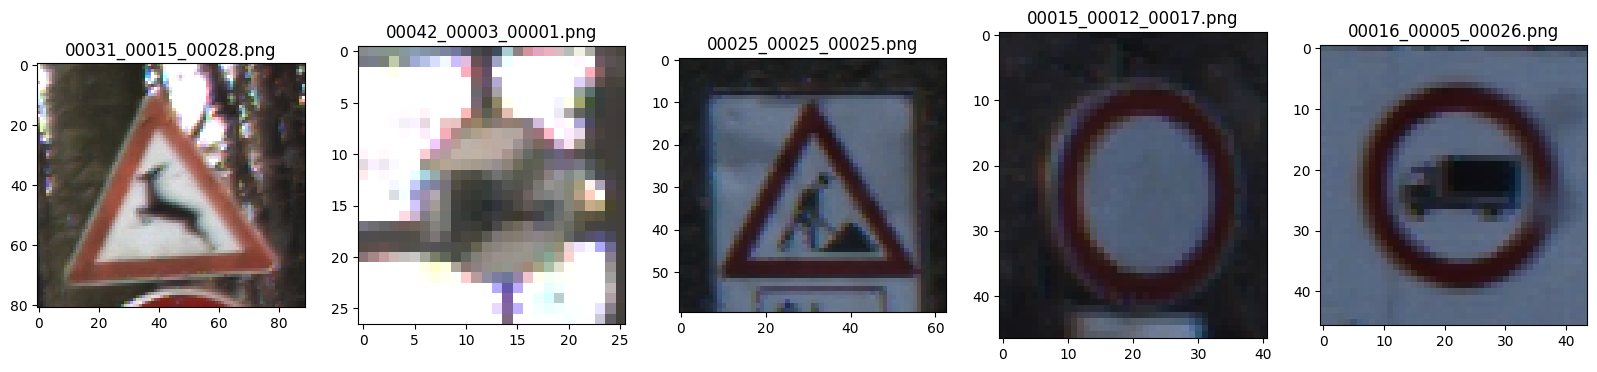

In [11]:
plt.figure(figsize=(20,20))
img_folder_1=os.path.join(img_folder, '1')
for i in range(5):
    file = random.choice(os.listdir(img_folder_1))
    image_path= os.path.join(img_folder_1, file)
    img=mpimg.imread(image_path)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Loading Datasets

In [35]:
def create_dataset(img_folder):

    img_data_array=[]
    class_name=[]
    IMG_WIDTH=100
    IMG_HEIGHT=100
    for dir1 in os.listdir(img_folder):
        for file in os.listdir(os.path.join(img_folder, dir1)):

            image_path= os.path.join(img_folder, dir1,  file)
            image= cv2.imread( image_path, cv2.COLOR_BGR2RGB)
            image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
            image=np.array(image)
            image = image.astype('float32')
            #image /= 255
            img_data_array.append(image)
            class_name.append(dir1)
    return img_data_array, class_name
# extract the image array and class name
img_data, class_name =create_dataset(img_folder)

In [36]:
def split_preprocess(X,y, data_path):
    #X, y= create_dataset(data_path)
    X, y = shuffle(X, y)
    X= np.array(X)
    y= np.array(y)
    X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle=True)
    y_train= y_train.astype(int)
    y_test= y_test.astype(int)
    X_train_preproc= preprocess_input(X_train).astype('float')
    X_test_preproc= preprocess_input(X_test).astype('float')
    return X_train_preproc, X_test_preproc, y_train, y_test
X_train_preproc, X_test_preproc, y_train, y_test= split_preprocess(img_data, class_name, img_folder)

In [ ]:
#images = tf.convert_to_tensor(img_data)
#images.shape
#y_class = np.array(class_name)

## Preprocessing/Scaling/Re-sizing Images

## Train & Test Datasets

In [30]:
from sklearn.utils import shuffle
import numpy as np

X = img_data
y = class_name
X, y = shuffle(X, y)
#print(X)
#print(y)

from sklearn.model_selection import train_test_split
X_train,X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)
X_train_tf = tf.convert_to_tensor(X_train)
y_train_array = np.array(y_train).astype(int)
X_test_tf = tf.convert_to_tensor(X_test)
y_test_array = np.array(y_test).astype(int)

## Base Model Initialization Function

In [31]:
def initialize_base_model():

    model = models.Sequential()

    ### First Convolution & MaxPooling
    # YOUR CODE HERE
    model.add(layers.Conv2D(8, (3,3), activation='relu', padding='same', input_shape=(100, 100, 3)))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(16, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Fourth Convolution & MaxPooling
    model.add(layers.Conv2D(32, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Fifth Convolution & MaxPooling
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    ### Flattening
    # YOUR CODE HERE
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    # YOUR CODE HERE
    model.add(layers.Dense(10, activation='relu'))


    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    # YOUR CODE HERE
    model.add(layers.Dense(1, activation='sigmoid'))

    ### Model compilation
    # YOUR CODE HERE
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model


In [32]:
def model_from_Federico(model):
  augmentation = Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(0.1),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomRotation(0.1)
    ])
  augment_model = Sequential([
        layers.Input(shape = (100,100,3)),
        augmentation,
        model])
  return augment_model

## VGG Model Initialization Function

In [37]:
def initialize_VGG_model():

    base_model= VGG16(weights='imagenet', input_shape=X_train_preproc[0,:,:].shape, include_top=False)
    base_model.trainable=False
    last_layer= base_model.output

    x= Flatten()(last_layer)
    x= Dense(1024, activation= 'relu')(x)
    x= Dense(512, activation= 'relu')(x)
    x= Dense(10, activation= 'relu')(x)
    output= Dense(1, activation= 'sigmoid')(x)

    model= Model(base_model.input, output)

    model.compile(loss='binary_crossentropy',
                optimizer = Adam(learning_rate= 1e-4),
                metrics=['accuracy'])
    return model

## Data Augmentation for VGG Model

In [ ]:
def data_augment(X_train_preproc, y_train, X_test_preproc, y_test,num, batch_size):
    train_datagen = ImageDataGenerator(featurewise_center = False,
        featurewise_std_normalization = False,
        rotation_range = 10,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        horizontal_flip = True,
        zoom_range = (0.8, 1.2))

    train_datagen.fit(X_train_preproc)
    train_size= int(X_train_preproc.shape[0] *num)

    X_train_aug= X_train_preproc[:train_size].astype('float')
    y_train_aug= y_train[:train_size].astype(int)

    X_val= X_train_preproc[train_size:].astype('float')
    y_val= y_train[train_size:].astype(int)

    X_test_preproc= X_test_preproc.astype('float')
    y_test= y_test.astype(int)

    train_flow = train_datagen.flow(X_train_aug, y_train_aug, batch_size = batch_size)
    return train_datagen, X_train_aug, y_train_aug, X_val, y_val, X_test_preproc, y_test

## Plotting History and Checking fitting function

In [33]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

## Base Model Compile and Train


Processing using Base Model...

Training model...
Epoch 1/25
34/34 [==============================] - 3s 15ms/step - loss: 0.6759 - accuracy: 0.5581 - val_loss: 0.6723 - val_accuracy: 0.5739
Epoch 2/25
34/34 [==============================] - 0s 10ms/step - loss: 0.6548 - accuracy: 0.5880 - val_loss: 0.6649 - val_accuracy: 0.6435
Epoch 3/25
34/34 [==============================] - 1s 15ms/step - loss: 0.6420 - accuracy: 0.6667 - val_loss: 0.6495 - val_accuracy: 0.7217
Epoch 4/25
34/34 [==============================] - 0s 12ms/step - loss: 0.6245 - accuracy: 0.6929 - val_loss: 0.6600 - val_accuracy: 0.5565
Epoch 5/25
34/34 [==============================] - 0s 12ms/step - loss: 0.5865 - accuracy: 0.6929 - val_loss: 0.5706 - val_accuracy: 0.7217
Epoch 6/25
34/34 [==============================] - 1s 15ms/step - loss: 0.5247 - accuracy: 0.7491 - val_loss: 0.5588 - val_accuracy: 0.7130
Epoch 7/25
34/34 [==============================] - 0s 15ms/step - loss: 0.5751 - accuracy: 0.7228 - va

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


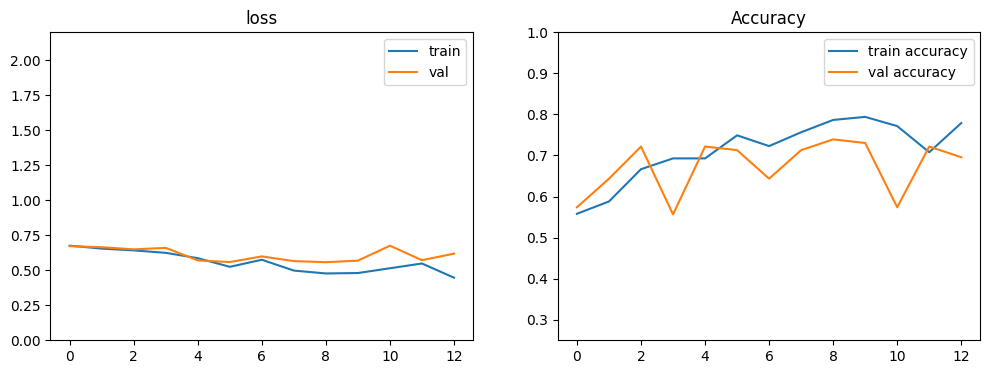

In [34]:
from tensorflow.keras.callbacks import EarlyStopping
#es = EarlyStopping(patience=4 ,restore_best_weights=True)
#es = EarlyStopping()
#model = initialize_model()
# Fit the model on the train data
#history = model.fit(X_train_tf, y_train_array, validation_split=0.3, epochs=25, batch_size=8, callbacks=[es], verbose=1)


def train_base_model(model: Model, X: np.ndarray, y: np.ndarray, batch_size=8, patience=4,
                     validation_data=None, validation_split=0.3):


    """
    Fit the model and return a tuple (fitted_model, history)
    """
    print(Fore.BLUE + "\nTraining model..." + Style.RESET_ALL)

    es = EarlyStopping(
        monitor="val_loss",
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )

    es = EarlyStopping(patience=4 ,restore_best_weights=True)
    model = initialize_base_model()
    # Fit the model on the train data
    history = model.fit(X, y, validation_split=0.3, epochs=25, batch_size=8, callbacks=[es], verbose=1)

    print(f"✅ Model trained with min val ACCURACY: {round(np.min(history.history['val_accuracy']), 2)}")

    return model, history


def evaluate_base_model(model: Model, X: np.ndarray, y: np.ndarray, batch_size=16):

    """
    Evaluate trained model performance on the dataset
    """
    print(Fore.BLUE + f"\nEvaluating model on {len(X)} rows..." + Style.RESET_ALL)
    if model is None:
        print(f"\n❌ No model to evaluate")
        return None

    metrics = model.evaluate(x=X, y=y, batch_size=batch_size, verbose=0, return_dict=True)
    loss = metrics["loss"]
    accuracy = metrics["accuracy"]

    print(f"✅ Model evaluated, Accuracy: {round(accuracy, 2)}")
    return metrics

print(Fore.GREEN + f"\nProcessing using Base Model..." + Style.RESET_ALL)
model1 = initialize_base_model()
model2 = model_from_Federico(model1)
#model1, history1 = train_base_model(model1, X_train_preproc, y_train)
model2, history1 = train_base_model(model2, X_train_tf, y_train_array)
plot_history(history1)
base_model_score = evaluate_base_model(model1, X_test_tf, y_test_array)

y_pred= model1.predict(X_test_tf)
y_pred= y_pred.astype(int)
target_names=['class_0', 'class_1']
print(classification_report(y_test_array, y_pred, target_names=target_names))



## VGG Model Compile and Train


Processing using VGG Model...
58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
10/10 [==============================] - 5s 205ms/step - loss: 1.0514 - accuracy: 0.5934 - val_loss: 0.5151 - val_accuracy: 0.7328
Epoch 2/50
10/10 [==============================] - 1s 57ms/step - loss: 0.3346 - accuracy: 0.8689 - val_loss: 0.3697 - val_accuracy: 0.8244
Epoch 3/50
10/10 [==============================] - 1s 55ms/step - loss: 0.1464 - accuracy: 0.9475 - val_loss: 0.3460 - val_accuracy: 0.8321
Epoch 4/50
10/10 [==============================] - 1s 57ms/step - loss: 0.0758 - accuracy: 0.9803 - val_loss: 0.4003 - val_accuracy: 0.8550
Epoch 5/50
10/10 [==============================] - 1s 63ms/step - loss: 0.0489 - accuracy: 0.9902 - val_loss: 0.3676 - val_accuracy: 0.8779
Epoch 6/50
10/10 [==============================] - 1s 54ms/step - loss: 0.0275 - accuracy: 0.9934 - val_loss: 0.3138 - val_accuracy: 0.8779
Epoch 7/50
4/4 [==============================] - 1s 226m

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


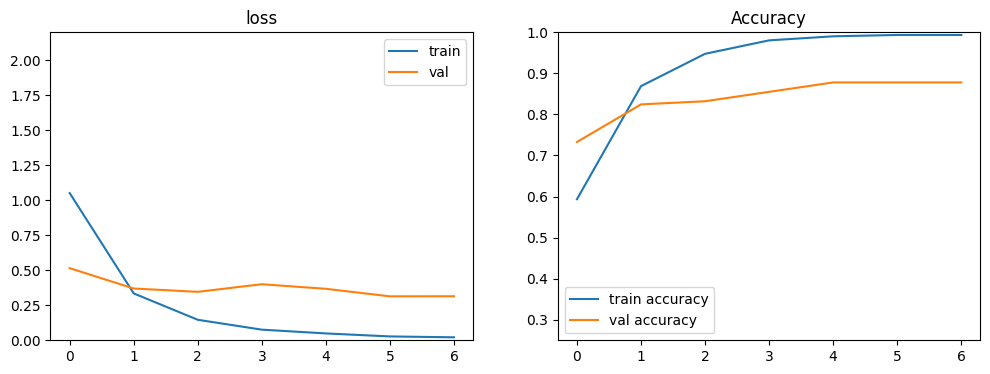

In [38]:
def train_VGG_model(model, X, y, validation_split, batch_size, patience):

    es= EarlyStopping(patience=patience, restore_best_weights=True, monitor= 'val_accuracy')
    history= model.fit(X, y, validation_split=validation_split, batch_size=batch_size, epochs=50, callbacks=[es],\
                  verbose=1)
    return model, history

def model_VGG_evaluate(model, X, y):

    score= model.evaluate(X, y)[1]
    print(f"✅ Model evaluated, Accuracy: {round(score, 2)}")
    return f'Test score= {score:.2f}'

print(Fore.YELLOW + f"\nProcessing using VGG Model..." + Style.RESET_ALL)
model= initialize_VGG_model()
model, history= train_VGG_model(model, X_train_preproc, y_train, 0.3, 32, 2)
plot_history(history)
vgg_model_score= model_VGG_evaluate(model, X_test_preproc, y_test)

y_pred= model.predict(X_test_preproc)
y_pred= y_pred.astype(int)
target_names=['class_0', 'class_1']
print(classification_report(y_test, y_pred, target_names=target_names))

## Data Augmentation VGG Model Compile and Train

In [ ]:
def train_VGG_augment(model_aug, train_datagen, X_train_aug, y_train_aug, X_val, y_val, batch_size, patience):
    train_flow = train_datagen.flow(X_train_aug, y_train_aug, batch_size = batch_size)
    es = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",factor=0.1,patience=patience,verbose=2
                                                      ,mode="max",min_delta=0.0001,cooldown=0,min_lr=0, momentum= 0.9)

    history_aug = model_aug.fit(train_flow,
                          epochs = 50,
                          callbacks = [es],
                          validation_data = (X_val, y_val))

    return model_aug, history_aug

print(Fore.MAGENTA + f"\nProcessing using Data Augmentation & VGG Model..." + Style.RESET_ALL)
train_datagen, X_train_aug, y_train_aug, X_val, y_val, X_test, y_test= data_augment(X_train_preproc, y_train, X_test_preproc, y_test, 0.80, 64)
model_aug= initialize_VGG_model()
model_aug, history_aug= train_VGG_augment(model_aug, train_datagen, X_train_aug, y_train_aug, X_val, y_val, 64, 2)
plot_history(history_aug)
aug_VGG_score= model_VGG_evaluate(model_aug, X_test_preproc, y_test)


Processing using Data Augmentation & VGG Model...
Epoch 1/50
6/6 [==============================] - 54s 9s/step - loss: 0.8621 - accuracy: 0.4868 - val_loss: 0.7049 - val_accuracy: 0.4186 - lr: 1.0000e-04
Epoch 2/50
6/6 [==============================] - 51s 9s/step - loss: 0.7067 - accuracy: 0.4809 - val_loss: 0.6778 - val_accuracy: 0.5814 - lr: 1.0000e-04
Epoch 3/50
6/6 [==============================] - 52s 10s/step - loss: 0.6997 - accuracy: 0.5630 - val_loss: 0.7460 - val_accuracy: 0.4186 - lr: 1.0000e-04
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.7066 - accuracy: 0.5279
Epoch 4: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.
6/6 [==============================] - 51s 10s/step - loss: 0.7066 - accuracy: 0.5279 - val_loss: 0.6640 - val_accuracy: 0.5814 - lr: 1.0000e-04
Epoch 5/50
6/6 [==============================] - 52s 9s/step - loss: 0.6707 - accuracy: 0.5836 - val_loss: 0.6692 - val_accuracy: 0.5930 - lr: 1.0000e-05
Epoch 6/50
6/6 

Epoch 37/50
2/6 [=========>....................] - ETA: 33s - loss: 0.6883 - accuracy: 0.5059

KeyboardInterrupt: 

## Model Summary and Parameters

In [ ]:
model.summary()

Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_125 (Conv2D)         (None, 100, 100, 8)       224       
                                                                 
 max_pooling2d_124 (MaxPooli  (None, 50, 50, 8)        0         
 ng2D)                                                           
                                                                 
 conv2d_126 (Conv2D)         (None, 48, 48, 16)        1168      
                                                                 
 max_pooling2d_125 (MaxPooli  (None, 24, 24, 16)       0         
 ng2D)                                                           
                                                                 
 conv2d_127 (Conv2D)         (None, 22, 22, 32)        4640      
                                                                 
 max_pooling2d_126 (MaxPooli  (None, 11, 11, 32)     

(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

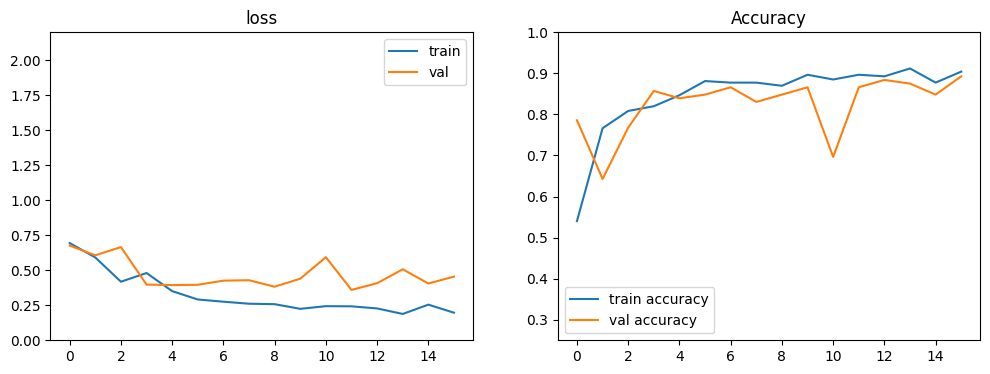

In [ ]:
plot_history(history)

## Model Evaluation and Probability Prediction

In [ ]:
model.evaluate(X_test_tf, y_test_array)

6/6 [==============================] - 1s 49ms/step - loss: 0.3447 - accuracy: 0.8634


[0.34467172622680664, 0.8633540272712708]